<div class="markdown-google-sans">

# **Sarcasm Detection on News Headlines**
</div>

In [58]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import gensim
import tensorflow as tf
import seaborn as sns


# Import required packages
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from sklearn.preprocessing import LabelEncoder # For label encoding
from sklearn.model_selection import train_test_split # For data partitioning
from gensim.corpora import Dictionary
from collections import Counter
from wordcloud import WordCloud # For WordCloud
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score


# Download extra packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<div class="markdown-google-sans">

# **Data Dictionary**
</div>

The dataset `Sarcasm_Headlines_Dataset.json` and `Sarcasm_Headlines_Dataset_v2.json` contain headlines of the news article obtained from The Onion, an American news source. The details of the datasets are described in the table below:

- Total Number of instances: 55328
- Total Number of variables: 3

| Variable     | Description                  |
| :----------- | :--------------------------- |
| `article_link` | Link of the news article    |
| `headline`     | Headline of the news article |
| `is_sarcastic` | Take value 1 if the headline of the news article is sarcastic, otherwise 0 |



## Data Understanding

<div class="markdown-google-sans">

## **Load and Read Dataset**
</div>

In [59]:
# Load and combine datasets
df1 = pd.read_json('https://raw.githubusercontent.com/Namitt/Sentiment-Analysis-with-Sarcasm-Detection/main/Sarcasm_Headlines_Dataset.json', lines = True)
df2 = pd.read_json('https://raw.githubusercontent.com/Namitt/Sentiment-Analysis-with-Sarcasm-Detection/main/Sarcasm_Headlines_Dataset_v2.json', lines = True)
df = pd.concat([df1, df2])
df.reset_index(drop = True, inplace = True)

In [60]:
# Read dataset
df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
55323,https://www.theonion.com/jews-to-celebrate-ros...,jews to celebrate rosh hashasha or something,1
55324,https://local.theonion.com/internal-affairs-in...,internal affairs investigator disappointed con...,1
55325,https://www.huffingtonpost.com/entry/andrew-ah...,the most beautiful acceptance speech this week...,0
55326,https://www.theonion.com/mars-probe-destroyed-...,mars probe destroyed by orbiting spielberg-gat...,1


The summary statistics below helps better understand the dataset.

In [61]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [62]:
df.groupby('is_sarcastic').describe().T

is_sarcastic                                                         0  \
article_link count                                               29970   
             unique                                              14984   
             top     https://www.huffingtonpost.comhttp://nymag.com...   
             freq                                                    4   
headline     count                                               29970   
             unique                                              14951   
             top                                        sunday roundup   
             freq                                                   20   

is_sarcastic                                                         1  
article_link count                                               25358  
             unique                                              13633  
             top     https://politics.theonion.com/nation-not-sure-...  
             freq                                                    3  
headline     count                                               25358  
             unique                                              13552  
             top     'no way to prevent this,' says only nation whe...  
             freq                                                   20

We observe the distribution of sarcastic and non-sarcastic headlines in the dataset.

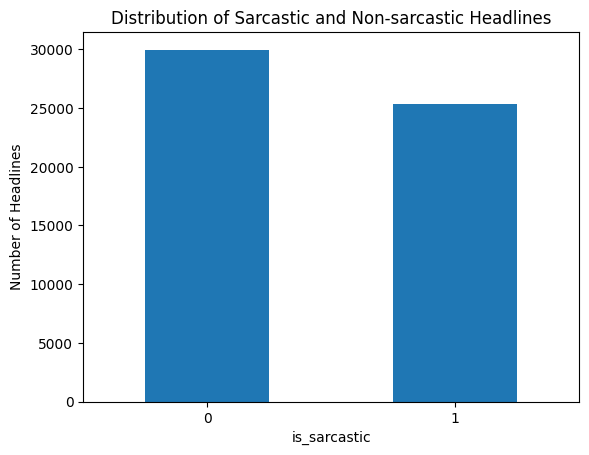

is_sarcastic
0    29970
1    25358
Name: count, dtype: int64

In [63]:
# Visualise the data after undersampling
df['is_sarcastic'].value_counts().plot(kind = 'bar', title = 'Distribution of Sarcastic and Non-sarcastic Headlines')
plt.xlabel('is_sarcastic')
plt.ylabel('Number of Headlines')
plt.xticks(rotation = 0)
plt.show()

# Distribution of sarcastic and non-sarcastic headlines
df['is_sarcastic'].value_counts()

After observing the distribution, we decide to use the full dataset without performing data balancing.

# Data Clearning & Quality Check

We remove the column `article_link` since it is independent to our analysis.

In [64]:
# Delete the column 'article_link'
df = df.drop(columns = 'article_link')

We ensure that the dataset is clean before modelling.

In [65]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      55328 non-null  object
 1   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 864.6+ KB


In [66]:
# Check if 'is_sarcastic' only contains 0 and 1
df['is_sarcastic'].isin([0, 1]).all()

True

# Label Encoding

<div class="markdown-google-sans">

## **Label Encoding**
</div>

We apply label encoding to `is_sarcastic`.

In [67]:
label_encoder = LabelEncoder()
df['is_sarcastic'] = label_encoder.fit_transform(df['is_sarcastic'])

## Data Preprocessing

In [68]:
# Data preprocessing function
stop_words = stopwords.words('english')
stop_words.remove('not')

nltk.download('wordnet')

lemm = WordNetLemmatizer()

def text_cleaning(x):
    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()
    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)
    return headline

df['clean_headline'] = df['headline'].apply(text_cleaning)
df['sentence_length'] = df['clean_headline'].apply(lambda x: len(x.split()))

df.drop(df[df['sentence_length'] > 40].index, inplace=True)
df.reset_index(inplace=True, drop=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [69]:
# Check dataframe after data preprocessing
df

,headline,is_sarcastic,clean_headline,sentence_length
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue secret black co...,10
1,the 'roseanne' revival catches up to our thorn...,0,roseanne revival catch thorny political mood b...,8
2,mom starting to fear son's web series closest ...,1,mom start fear son web series closest thing gr...,9
3,"boehner just wants wife to listen, not come up...",1,boehner want wife listen not come alternative ...,10
4,j.k. rowling wishes snape happy birthday in th...,0,j k rowling wish snape happy birthday magical way,9
...,...,...,...,...
55322,jews to celebrate rosh hashasha or something,1,jews celebrate rosh hashasha something,5
55323,internal affairs investigator disappointed con...,1,internal affairs investigator disappoint consp...,8
55324,the most beautiful acceptance speech this week...,0,beautiful acceptance speech week come queer ko...,7
55325,mars probe destroyed by orbiting spielberg-gat...,1,mar probe destroy orbit spielberg gate space p...,8


## EDA

<div class="markdown-google-sans">

## **Data Understanding & Visualisation**
</div>

Next, we visualise the words from sarcastic and non-sarcastic headlines and compare the results.

<div class="markdown-google-sans">

### **Visualise Words from Sarcastic Headlines**
</div>



In [70]:
# Extract sarcastic headlines
condition = df['is_sarcastic'] == 1

# Create list of tokens
token = df.loc[condition, 'headline'].apply(nltk.word_tokenize)
documents = token.tolist()

# Create the dictionary
dictionary = Dictionary(documents) # List of lists

# Filter extremes from the dictionary
dictionary.filter_extremes(no_below = 5, no_above = 0.5) # At least appears in 5 documents, no more than 50%

# Create bag-of-words representation
corpus = [dictionary.doc2bow(document) for document in documents]

<div class="*markdown*-google-sans">

#### **Bag-of-Words**
</div>

Perform frequency analysis by Bag-of-Words.

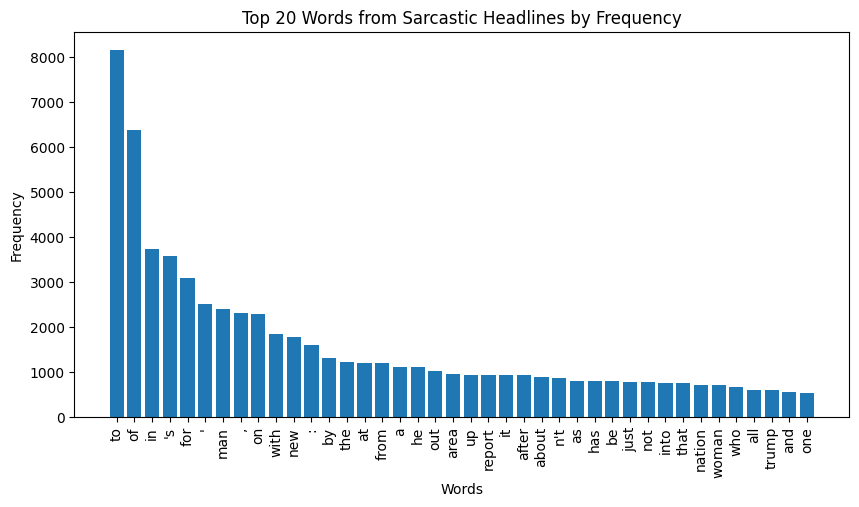

In [71]:
# Summing up the counts from the BoW corpus
total_word_count = Counter(word_id for document in corpus for word_id, count in document)

# Mapping back the word IDs to words
mapped_word_counts = [(dictionary[word_id], count) for word_id, count in total_word_count.items()]

# Sort words by frequency
sorted_word_counts = sorted(mapped_word_counts, key=lambda w: w[1], reverse=True)

# Let's plot the top words
plt.figure(figsize=(10, 5))
words, counts = zip(*sorted_word_counts[:40])
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words from Sarcastic Headlines by Frequency')
plt.xticks(rotation = 90)
plt.show()

<div class="markdown-google-sans">

#### **World Cloud**
</div>

Visualize the most frequent words using WordCloud.

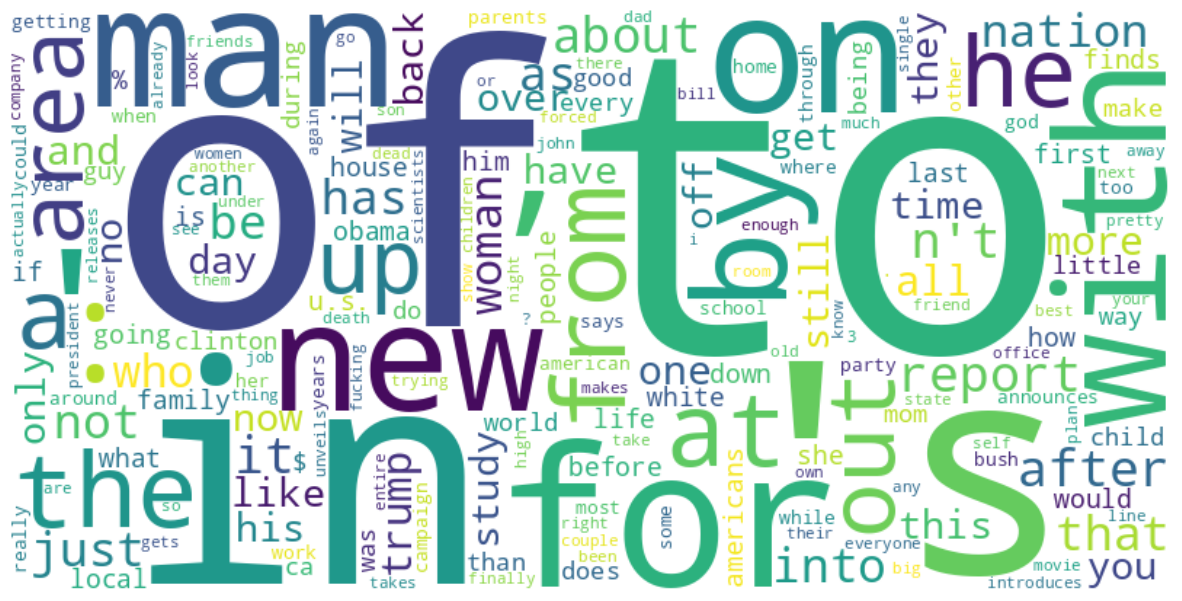

In [72]:
# Creating a dictionary for word cloud
word_freq_dict = dict(sorted_word_counts)

# Creating word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate_from_frequencies(word_freq_dict)

# Displaying the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

<div class="markdown-google-sans">

### **Visualise Words from Non-sarcastic Headlines**
</div>

Visualise the most frequent words by WorldCloud

In [73]:
# Extract sarcastic headlines
condition = df['is_sarcastic'] == 0

# Create list of tokens
token = df.loc[condition, 'headline'].apply(nltk.word_tokenize)
documents = token.tolist()

# Create the dictionary
dictionary = Dictionary(documents) # List of lists

# Filter extremes from the dictionary
dictionary.filter_extremes(no_below = 5, no_above = 0.5) # At least appears in 5 documents, no more than 50%

# Create bag-of-words representation
corpus = [dictionary.doc2bow(document) for document in documents]

<div class="markdown-google-sans">

#### **Bag-of-Words**
</div>

Perform frequency analysis by Bag-of-Words.

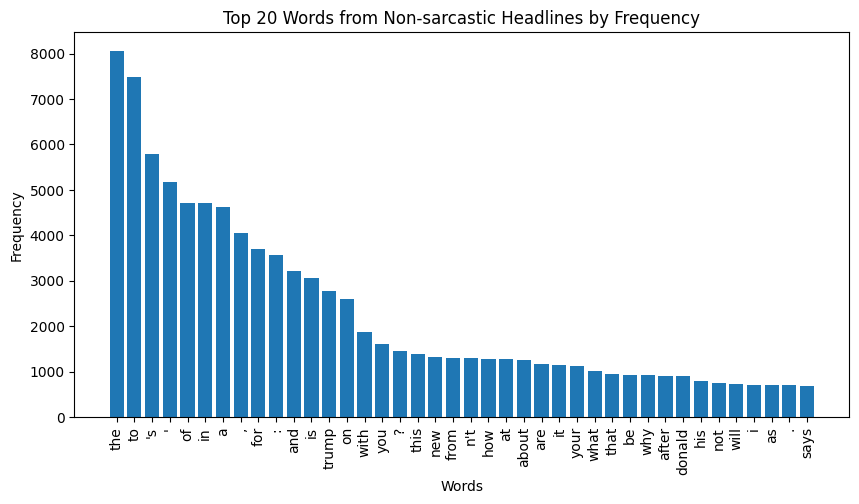

In [74]:
# Summing up the counts from the BoW corpus
total_word_count = Counter(word_id for document in corpus for word_id, count in document)

# Mapping back the word IDs to words
mapped_word_counts = [(dictionary[word_id], count) for word_id, count in total_word_count.items()]

# Sort words by frequency
sorted_word_counts = sorted(mapped_word_counts, key=lambda w: w[1], reverse=True)

# Let's plot the top words
plt.figure(figsize=(10, 5))
words, counts = zip(*sorted_word_counts[:40])
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words from Non-sarcastic Headlines by Frequency')
plt.xticks(rotation = 90)
plt.show()

<div class="markdown-google-sans">

#### **World Cloud**
</div>

Visualize the most frequent words using WordCloud.

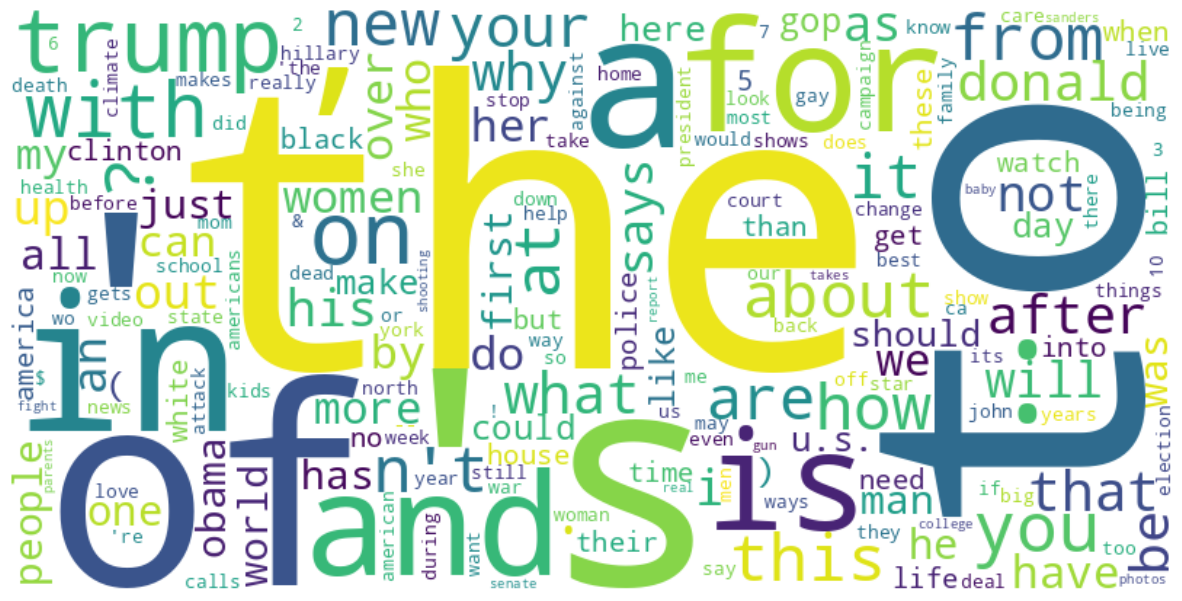

In [75]:
# Creating a dictionary for word cloud
word_freq_dict = dict(sorted_word_counts)

# Creating word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate_from_frequencies(word_freq_dict)

# Displaying the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

<div class="markdown-google-sans">

## **Data Partitioning**
</div>

We split the dataset into 70% for training and 30% for testing.

In [76]:
# Define feature and target variable
headline = df['headline'] # Feature
is_sarcastic = df['is_sarcastic'] # Target variable

# Split the dataset into training and testing sets
x_train, x_val, y_train, y_val = train_test_split(headline, is_sarcastic, test_size=0.2, stratify=is_sarcastic, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [77]:
#check the size of data
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(44261,)
(44261,)
(5533,)
(5533,)
(5533,)
(5533,)


<div class="markdown-google-sans">

## **Preprocessing on Training and Test Data**
</div>

In [78]:
# Define pre-processing parameters
max_len = 40 # Max number of words in each headline
padding_type = 'post'
trunc_type = 'post'

<div class="markdown-google-sans">

### **Tokenisation on Training Data**
</div>

In [79]:
# Tokenisation on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ", vocab_size)

Vocab Size:  30087


<div class="markdown-google-sans">

### **Sequence and Padding on Training and Test Data**
</div>

In [80]:
# Padding on training, validation and testing data
x_train_pad = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_len, padding=padding_type, truncating=trunc_type)
x_val_pad = pad_sequences(tokenizer.texts_to_sequences(x_val), maxlen=max_len, padding=padding_type, truncating=trunc_type)
x_test_pad = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_len, padding=padding_type, truncating=trunc_type)

<div class="markdown-google-sans">

# **Modeling**
</div>

<div class="markdown-google-sans">

## **LSTM**
</div>

In [81]:
# Define parameters
embedding_dim = 100 # Dimension of word embeddings
drop_lstm = 0.2
lstm_units = 64 # Number of units in the LSTM layer

# Build LTSM model
model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model_LSTM.add(SpatialDropout1D(drop_lstm))
model_LSTM.add(LSTM(lstm_units, return_sequences = False))
model_LSTM.add(Dropout(drop_lstm))
model_LSTM.add(Dense(1, activation = 'sigmoid'))

# Model summary
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 40, 100)           3008700   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 40, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3051005 (11.64 MB)
Trainable params: 3051005 (11.64 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [82]:
# Compile the model
model_LSTM.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [83]:
# Train the model
epochs_num = 10
batch_size = 32
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

history = model_LSTM.fit(x_train_pad,
               y_train,
               epochs = epochs_num,
               batch_size = batch_size,
               validation_data = (x_val_pad, y_val),
               callbacks = [early_stop],
               verbose = 2)

Epoch 1/10
1384/1384 - 19s - loss: 0.5488 - accuracy: 0.7360 - val_loss: 0.4709 - val_accuracy: 0.8218 - 19s/epoch - 14ms/step
Epoch 2/10
1384/1384 - 9s - loss: 0.5068 - accuracy: 0.7764 - val_loss: 0.5507 - val_accuracy: 0.7338 - 9s/epoch - 7ms/step
Epoch 3/10
1384/1384 - 8s - loss: 0.5566 - accuracy: 0.7168 - val_loss: 0.6009 - val_accuracy: 0.6665 - 8s/epoch - 6ms/step


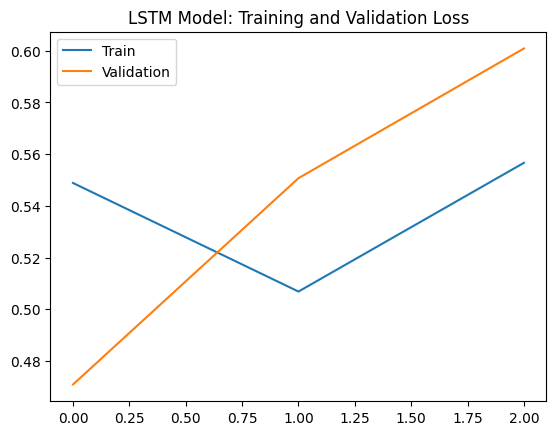

In [84]:
# Plot loss graph
plt.title('LSTM Model: Training and Validation Loss')
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()
plt.show();

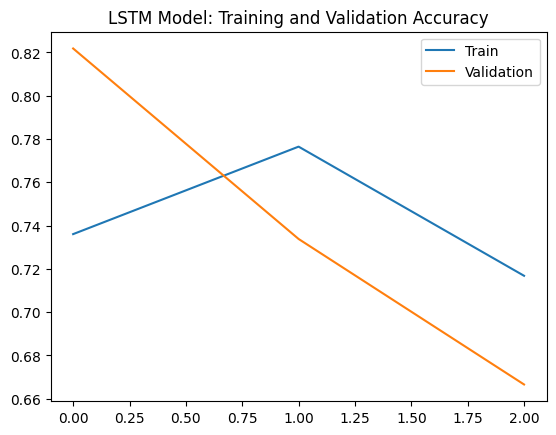

In [85]:
# Plot accuracy graph
plt.title('LSTM Model: Training and Validation Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()
plt.show();

<div class="markdown-google-sans">

## **Bi-LSTM**
</div>

In [86]:
# Build LTSM model
model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model_BiLSTM.add(Bidirectional(LSTM(lstm_units, return_sequences = False)))
model_BiLSTM.add(Dropout(drop_lstm))
model_BiLSTM.add(Dense(1, activation = 'sigmoid'))

# Model summary
model_BiLSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 40, 100)           3008700   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3093309 (11.80 MB)
Trainable params: 3093309 (11.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
# Compile the model
model_BiLSTM.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [88]:
# Train the model
epochs_num = 10
batch_size = 32
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

history = model_BiLSTM.fit(x_train_pad,
               y_train,
               epochs = epochs_num,
               batch_size = batch_size,
               validation_data = (x_val_pad, y_val),
               callbacks = [early_stop],
               verbose = 2)

Epoch 1/10
1384/1384 - 25s - loss: 0.2827 - accuracy: 0.8751 - val_loss: 0.1653 - val_accuracy: 0.9360 - 25s/epoch - 18ms/step
Epoch 2/10
1384/1384 - 12s - loss: 0.0774 - accuracy: 0.9735 - val_loss: 0.1163 - val_accuracy: 0.9593 - 12s/epoch - 9ms/step
Epoch 3/10
1384/1384 - 12s - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.1275 - val_accuracy: 0.9633 - 12s/epoch - 9ms/step
Epoch 4/10
1384/1384 - 11s - loss: 0.0112 - accuracy: 0.9966 - val_loss: 0.1594 - val_accuracy: 0.9667 - 11s/epoch - 8ms/step


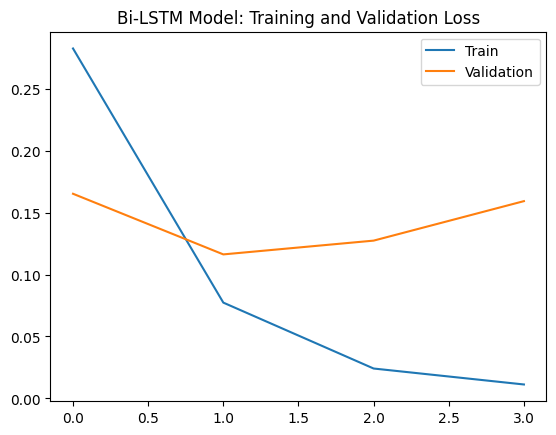

In [89]:
# Plot loss graph
plt.title('Bi-LSTM Model: Training and Validation Loss')
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()
plt.show();

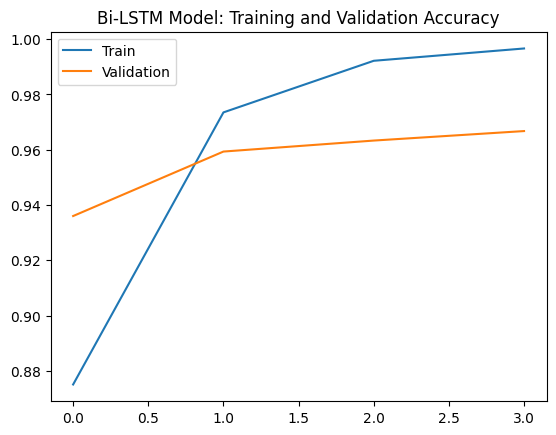

In [90]:
# Plot accuracy graph
plt.title('Bi-LSTM Model: Training and Validation Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()
plt.show();

<div class="markdown-google-sans">

## **Attention-based LSTM**
</div>

In [91]:
#define an attention layer

from keras.layers import Layer
import keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='normal')
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Simplest form of attention: softmax(weights) * inputs
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [92]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.activations import tanh

# Define parameters
embedding_dim = 100 # Dimension of word embeddings
drop_lstm = 0.2
lstm_units = 64 # Number of units in the LSTM layer

# Define the model with attention mechanism using functional API
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input_layer)
dropout_emb = SpatialDropout1D(drop_lstm)(embedding_layer)
lstm_layer = LSTM(lstm_units, return_sequences=True)(dropout_emb)  # Set return_sequences=True for attention
attention_layer = AttentionLayer()(lstm_layer)
dropout_att = Dropout(0.5)(attention_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_att)

# Build and compile the model
model_AttLSTM = Model(inputs=input_layer, outputs=output_layer)

# Display the model summary to check the structure
model_AttLSTM.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 40, 100)           3008700   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 40, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_5 (LSTM)               (None, 40, 64)            42240     
                                                                 
 attention_layer_1 (Attenti  (None, 64)                104       
 onLayer)                                                        
                                                                 
 dropout_8 (Dropout)         (None, 64)                0   

In [93]:
#compile the model
model_AttLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [94]:
# Set training parameters
epochs_num = 10
batch_size = 32

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history = model_AttLSTM.fit(x_train_pad,
                            y_train,
                            epochs=epochs_num,
                            batch_size=batch_size,
                            validation_data=(x_val_pad, y_val),
                            callbacks=[early_stop],
                            verbose=2)

Epoch 1/10
1384/1384 - 21s - loss: 0.3278 - accuracy: 0.8534 - val_loss: 0.2114 - val_accuracy: 0.9192 - 21s/epoch - 15ms/step
Epoch 2/10
1384/1384 - 9s - loss: 0.1259 - accuracy: 0.9564 - val_loss: 0.1579 - val_accuracy: 0.9422 - 9s/epoch - 7ms/step
Epoch 3/10
1384/1384 - 10s - loss: 0.0643 - accuracy: 0.9780 - val_loss: 0.1592 - val_accuracy: 0.9516 - 10s/epoch - 7ms/step
Epoch 4/10
1384/1384 - 10s - loss: 0.0384 - accuracy: 0.9871 - val_loss: 0.1510 - val_accuracy: 0.9619 - 10s/epoch - 7ms/step
Epoch 5/10
1384/1384 - 10s - loss: 0.0237 - accuracy: 0.9917 - val_loss: 0.2069 - val_accuracy: 0.9586 - 10s/epoch - 7ms/step
Epoch 6/10
1384/1384 - 9s - loss: 0.0179 - accuracy: 0.9939 - val_loss: 0.2012 - val_accuracy: 0.9633 - 9s/epoch - 6ms/step


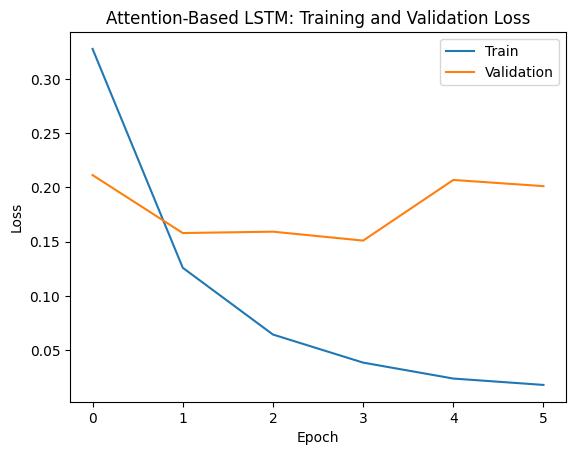

In [95]:
# Plot loss graph
plt.title('Attention-Based LSTM: Training and Validation Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

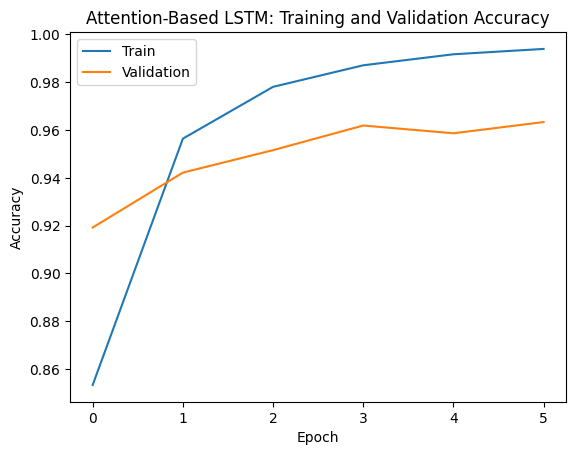

In [96]:
# Plot accuracy graph
plt.title('Attention-Based LSTM: Training and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<div class="markdown-google-sans">

## **Transformer**
</div>

In [97]:
# Multi-Headed Attention
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [98]:
# Model Definition
embed_dim = 50
heads = 2
neurons = 32
maxlen = 40

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_trans = Model(inputs=inputs, outputs=outputs)

# Model Summary
model_trans.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model_trans.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40)]              0         
                                                                 
 token_and_position_embeddi  (None, 40, 50)            1506350   
 ng_1 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_encoder_1 (Tra  (None, 40, 50)            23832     
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_1  (None, 50)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_11 (Dropout)        (None, 50)                0   

In [99]:
# Model Training
model_name = "model_trans.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=1, verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [100]:
# Model Fitting
history = model_trans.fit(x_train_pad, y_train,
                    validation_data=(x_val_pad, y_val),
                    epochs=10,
                    batch_size=32,
                    callbacks=[earlystopping, checkpoint])

Epoch 1/10
1384/1384 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8056
Epoch 1: val_loss improved from inf to 0.22533, saving model to model_trans.keras
1384/1384 [==============================] - 26s 16ms/step - loss: 0.3940 - accuracy: 0.8056 - val_loss: 0.2253 - val_accuracy: 0.9044
Epoch 2/10
1384/1384 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9498
Epoch 2: val_loss improved from 0.22533 to 0.18088, saving model to model_trans.keras
1384/1384 [==============================] - 14s 10ms/step - loss: 0.1406 - accuracy: 0.9498 - val_loss: 0.1809 - val_accuracy: 0.9380
Epoch 3/10
1384/1384 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9807
Epoch 3: val_loss improved from 0.18088 to 0.16453, saving model to model_trans.keras
1384/1384 [==============================] - 13s 10ms/step - loss: 0.0619 - accuracy: 0.9807 - val_loss: 0.1645 - val_accuracy: 0.9593
Epoch 4/10
1384/1384 [=========================

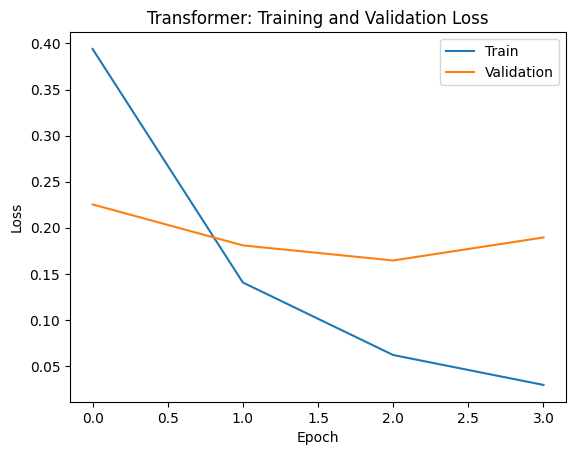

In [101]:
# Plot loss graph
plt.title('Transformer: Training and Validation Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

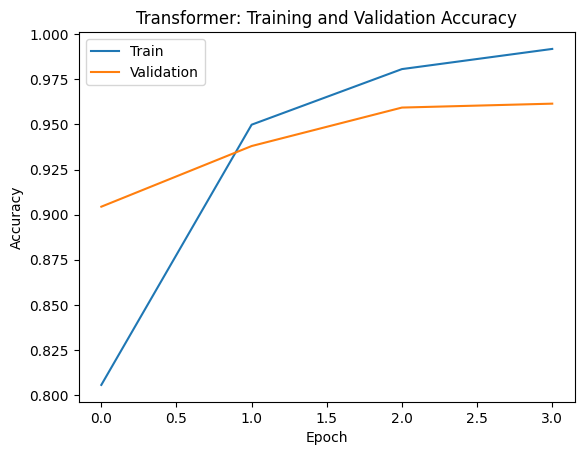

In [102]:
# Plot accuracy graph
plt.title('Transformer: Training and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<div class="markdown-google-sans">

# **Model Comparisons**
</div>

In [103]:
#make sarcasm prediction on test data
y_prob_lstm = model_LSTM.predict(x_test_pad)
y_prob_bilstm = model_BiLSTM.predict(x_test_pad)
y_prob_attlstm = model_AttLSTM.predict(x_test_pad)
y_prob_trans = model_trans.predict(x_test_pad)

173/173 [==============================] - 1s 3ms/step


<div class="markdown-google-sans">

## **ROC Curve**
</div>

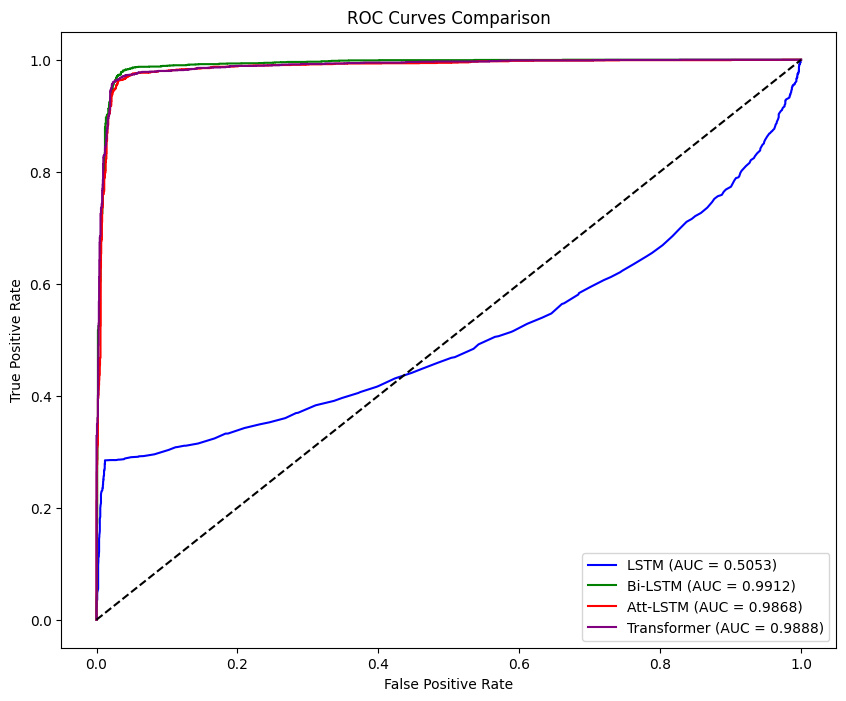

In [104]:
#Compute ROC Metrics for Each Model
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_prob_lstm)
fpr_bilstm, tpr_bilstm, _ = roc_curve(y_test, y_prob_bilstm)
fpr_attlstm, tpr_attlstm, _ = roc_curve(y_test, y_prob_attlstm)
fpr_trans, tpr_trans, _ = roc_curve(y_test, y_prob_trans)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

auc_lstm = auc(fpr_lstm, tpr_lstm)
auc_bilstm = auc(fpr_bilstm, tpr_bilstm)
auc_attlstm = auc(fpr_attlstm, tpr_attlstm)
auc_trans = auc(fpr_trans, tpr_trans)

#plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.4f})', color='blue')
plt.plot(fpr_bilstm, tpr_bilstm, label=f'Bi-LSTM (AUC = {auc_bilstm:.4f})', color='green')
plt.plot(fpr_attlstm, tpr_attlstm, label=f'Att-LSTM (AUC = {auc_attlstm:.4f})', color='red')
plt.plot(fpr_trans, tpr_trans, label=f'Transformer (AUC = {auc_trans:.4f})', color='purple')

plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.show()

<div class="markdown-google-sans">

## **Accuracy Measure**
</div>

In [105]:
from sklearn.metrics import accuracy_score
# Convert probabilities to binary labels
y_pred_lstm = (y_prob_lstm > 0.5).astype(int)
y_pred_bilstm = (y_prob_bilstm > 0.5).astype(int)
y_pred_attlstm = (y_prob_attlstm > 0.5).astype(int)
y_pred_trans = (y_prob_trans > 0.5).astype(int)

# Calculate accuracy for each model
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
accuracy_bilstm = accuracy_score(y_test, y_pred_bilstm)
accuracy_attlstm = accuracy_score(y_test, y_pred_attlstm)
accuracy_trans = accuracy_score(y_test, y_pred_trans)

# Print the accuracies
print(f"Accuracy of LSTM model: {accuracy_lstm:.4f}")
print(f"Accuracy of Bi-LSTM model: {accuracy_bilstm:.4f}")
print(f"Accuracy of Att-LSTM model: {accuracy_attlstm:.4f}")
print(f"Accuracy of Transformer model: {accuracy_trans:.4f}")


Accuracy of LSTM model: 0.6644
Accuracy of Bi-LSTM model: 0.9691
Accuracy of Att-LSTM model: 0.9639
Accuracy of Transformer model: 0.9653


<div class="markdown-google-sans">

## **Recall, Precision, F1 Score**
</div>

In [106]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each model
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

precision_bilstm = precision_score(y_test, y_pred_bilstm)
recall_bilstm = recall_score(y_test, y_pred_bilstm)
f1_bilstm = f1_score(y_test, y_pred_bilstm)

precision_attlstm = precision_score(y_test, y_pred_attlstm)
recall_attlstm = recall_score(y_test, y_pred_attlstm)
f1_attlstm = f1_score(y_test, y_pred_attlstm)

precision_trans = precision_score(y_test, y_pred_trans)
recall_trans = recall_score(y_test, y_pred_trans)
f1_trans = f1_score(y_test, y_pred_trans)

# Print precision, recall, and F1 score for each model
print("Model Performance Comparison:")
print("LSTM:")
print(f"Precision: {precision_lstm:.4f}, Recall: {recall_lstm:.4f}, F1 Score: {f1_lstm:.4f}")

print("Bi-LSTM:")
print(f"Precision: {precision_bilstm:.4f}, Recall: {recall_bilstm:.4f}, F1 Score: {f1_bilstm:.4f}")

print("Att-LSTM:")
print(f"Precision: {precision_attlstm:.4f}, Recall: {recall_attlstm:.4f}, F1 Score: {f1_attlstm:.4f}")

print("Transformer:")
print(f"Precision: {precision_trans:.4f}, Recall: {recall_trans:.4f}, F1 Score: {f1_trans:.4f}")

Model Performance Comparison:
LSTM:
Precision: 0.9521, Recall: 0.2819, F1 Score: 0.4350
Bi-LSTM:
Precision: 0.9676, Recall: 0.9649, F1 Score: 0.9662
Att-LSTM:
Precision: 0.9657, Recall: 0.9550, F1 Score: 0.9603
Transformer:
Precision: 0.9737, Recall: 0.9499, F1 Score: 0.9617


<div class="markdown-google-sans">

# **Best Model**
</div>

Best model is Bi-LSTM, with 0.9671 accuracy and 0.9639 F1 score on testing data.

Confusion Matrix

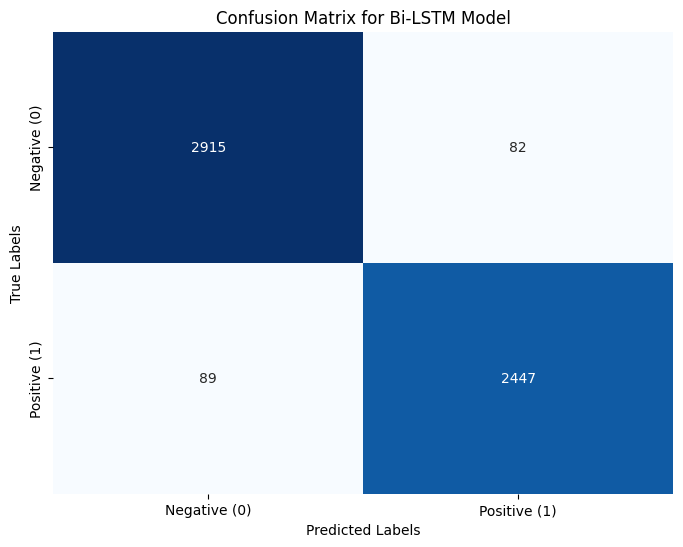

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Bi-LSTM Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Negative (0)', 'Positive (1)'])
plt.yticks([0.5, 1.5], ['Negative (0)', 'Positive (1)'], va='center')
plt.show()

<div class="markdown-google-sans">

# **Sentiment Analysis**
</div>

In [108]:
# Vader
!pip install vaderSentiment

In [109]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Function to get sentiment using VADER
def get_vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(text)['compound']
    return sentiment_score

In [110]:
# Apply VADER sentiment analysis to the headlines
df['Sentiment_VADER'] = df['clean_headline'].apply(get_vader_sentiment)

In [111]:
df

,headline,is_sarcastic,clean_headline,sentence_length,Sentiment_VADER
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue secret black co...,10,0.0000
1,the 'roseanne' revival catches up to our thorn...,0,roseanne revival catch thorny political mood b...,8,-0.3182
2,mom starting to fear son's web series closest ...,1,mom start fear son web series closest thing gr...,9,-0.4939
3,"boehner just wants wife to listen, not come up...",1,boehner want wife listen not come alternative ...,10,0.3421
4,j.k. rowling wishes snape happy birthday in th...,0,j k rowling wish snape happy birthday magical way,9,0.7506
...,...,...,...,...,...
55322,jews to celebrate rosh hashasha or something,1,jews celebrate rosh hashasha something,5,0.5719
55323,internal affairs investigator disappointed con...,1,internal affairs investigator disappoint consp...,8,-0.6486
55324,the most beautiful acceptance speech this week...,0,beautiful acceptance speech week come queer ko...,7,0.7845
55325,mars probe destroyed by orbiting spielberg-gat...,1,mar probe destroy orbit spielberg gate space p...,8,-0.5423


In [112]:
# Function to determine output based on VADER sentiment and is_sarcastic
def get_output(sentiment_vader, is_sarcastic):
    if sentiment_vader < 0 and is_sarcastic == 0:
        return 'Negative'
    elif sentiment_vader < 0 and is_sarcastic == 1:
        return 'Negative'
    elif sentiment_vader > 0 and is_sarcastic == 0:
        return 'Positive'
    elif sentiment_vader > 0 and is_sarcastic == 1:
        return 'Negative'
    elif sentiment_vader == 0 and is_sarcastic == 1:
        return 'Negative'
    elif sentiment_vader == 0 and is_sarcastic == 0:
        return 'Neutral'

# Apply the function to create the 'Output' column
df['Output'] = df.apply(lambda row: get_output(row['Sentiment_VADER'], row['is_sarcastic']), axis=1)


In [113]:
# Calculate the frequency of each value in the "Output" column
output_counts = df['Output'].value_counts()

# Get the counts for "positive", "negative", and "neutral"
positive_count = output_counts.get('Positive', 0)
negative_count = output_counts.get('Negative', 0)
neutral_count = output_counts.get('Neutral', 0)

# Calculate the total count
total_count = positive_count + negative_count + neutral_count

# Calculate the ratios
positive_ratio = positive_count / total_count
negative_ratio = negative_count / total_count
neutral_ratio = neutral_count / total_count

print("Positive:Negative:Neutral ratios:", positive_ratio, negative_ratio, neutral_ratio)

Positive:Negative:Neutral ratios: 0.1785746561353408 0.6380067598098578 0.18341858405480146
